# Dynamic Pricing with Reinforcement Learning - Multi Armed Bandits

# SECTION 1. Dynamic Pricing and Bandits

## 1. Introduction to Dynamic Pricing

Dynamic pricing, aka demand based pricing or time based pricing is a strategy where businesses set flexible prices for products or services, typically to maximize revenue/profit.

This is in contrast to traditional pricing where prices are set for extended periods and don't fluctuate with market changes. 

Dynamic pricing may be applicable to products where the business has the flexibility to modify the price frequently based on demand and other factors. This can potentially impact the revenue and profitability. 

1. ECommerce and retail
2. Ride sharing apps
3. Airlines ticket pricing
4. Hotel accomodation pricing
5. Online Ads (PPC models)
6. Energy pricing


## 2. Overview of Multi Armed Bandit (MAB)

A bandit is a money thief. A one-armed bandit seen in casinos is a simple slot machine where you insert a coin and pull a lever and you get a reward or not. 

A multi-armed bandit is a slot machine with multiple levers that the gambler can pull, but pulling each lever gives a different reward. The probability distribution of the reward is different for each lever, but is unknown to the gambler.

Using reinforcement learning it is possible to learn which arm to pull to maximize the rewards, with repeated experiments (actions).

__Bernoulli Multi Armed Bandit__

When an action has only two outcomes (reward=1, no-reward=0), then it can be considered as a Bernoulli MAB.

__Goal:__ Learn which lever to pull to maximize the rewards. 

No prior knowledge of the average rewards is assumed. No prior data be used. 

<img src="multiarmedbandits.png" width=600 height=400/>

There are multiple strategies to tackling the MAB problem:

1. Greedy
2. ϵ-greedy (Epsilon Greedy)
3. UCB1 (Upper Confidence Bound)
4. Thompson Sampling

Let's explore the various approaches and their outcomes when we start solving.

Source: [Dynamic pricing MAB](https://towardsdatascience.com/dynamic-pricing-with-multi-armed-bandit-learning-by-doing-3e4550ed02ac)

## 3. Regret

Regret is the differnce between the maximum possible and the expected reward. The loss we incur when making repeated trials by pulling suboptimal arms in the process of learning is called regret.


<img src="regret.png" width=600 height=400/>


## 4. Problem Statement

Let's say you own a eComm store selling new product. Like most owners, you are not certain about it's optimal price. 

However, you do have a sense that your product will sell between a lower and uppper bound of price range. 

Use repeated trials an come up with a strategy to find the optimal selling price for your product in the store so as to maximize revenues.

<img src="storefront.png" width=400 height=300/>0

__What can be considered as the actual demand?__

You may assume the demand curve (probability of purchase) follows the following equation as the price increases:

$$ Prob(Purchase) = \frac{a}{1 + e^{(b*price)}}$$) 

<img src="demand_curve.png" width=400 height=300/>

$$ Expected \;Return = \frac{a.price}{1 + e^{(b*price)}}$$) 

<img src="expected_returns.png" width=400 height=300/>

__Note:__ The derivative for the expected returns formula is as follows. You may use this to find the price that gives the maximum returns by equating this to 0.

<img src="derivative_formula.png" width=400 height=300/>

For this problem, let's set a=1.5 and b=0.04. This will give a target price of 31.96, with probability of purchase of 0.3267. This would translate to an optimal average reward of 31.9616 * 0.3267 = 10.44.

This target price is assumed as the actual real world data, which is the answer that the MAB nas to find out using repeated trials. So, these numbers are NOT to be exposed to the algorithm.

In [5]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import bernoulli

# prob(purchase) for a given price at fixed a and b.
def prob_purchase(price, a=1.5, b=0.04):
    return a / (1 + np.exp(b * price))

# revenue derivative to compute the optimal price. 
# This is the price the model has to learn
def revenue_derivative(x, a=1.5, b=0.04):
    # derivative price (x) * prob_purchase
    return a / (np.exp(b * x) + 1) - (a * b * x * np.exp(b * x)) / (np.exp(b * x) + 1) ** 2

# Determine the optimal price to maximize revenue.
def get_optimal_price(a=1.5, b=0.04):
    return fsolve(revenue_derivative, 0, args=(a, b))[0]

# Use bernoulli distribution to get the outcome (reward) of a trial, when the prob(purchase) is given.
def get_reward(price, a=1.5, b=0.04):
    prob = prob_purchase(price, a, b)
    return bernoulli.rvs(prob)

__Probability of purchase example__

In [6]:
print(prob_purchase(21, a=1.5,b=0.04))
print(prob_purchase(57, a=1.5,b=0.04))

0.4523021759961919
0.13918942967573547


__Target price__

In [19]:
optimal_price = get_optimal_price(a=1.5, b=0.04)
optimal_price

31.961613569026845

Apply the price to `prob_purchase` to get the purchase probability.

In [27]:
optimal_probability = prob_purchase(31.9616, a=1.5, b=0.04)
optimal_probability 

0.32671769728483757

__Optimal average reward__

In [9]:
31.9616 * 0.3267

10.44185472

# SECTION 2: Greedy Algorithm

## 5. Greedy Strategy

Greedy strategy is one where you go for the arm that gave the maximum reward every time. 

However, since we do not know which arm gives good rewards, we pick the arms randomly initially. Then, after trying out the machines for a while, it sticks to the machine that did the best. 

__Exploration vs Exploitation__

Exploration is when we play different arms to understand how they perform, primarily to gather information. This is done especially, when the rewards of the arms are unknown.

Exploitation is when we know certain arm(s) give good reward and we exploit this information to gain the reward, instead of taking the 'risk' of exploration.

The greedy algorithm is one where mostly 'exploit' your initial knowledge of the arms rewards. 



In [10]:
def greedy(arm_avg_reward):
    if np.all(arm_avg_reward == 0):
        # if no reward, go random
        arm = np.random.choice(len(arm_avg_reward))
    else:
        # else choose the arm with highest average reward
        arm = np.argmax(arm_avg_reward)
    return arm

# SECTION 3: Epsilon Greedy Algorithm

## 6. Epsilon Greedy approach

While greedy approach is all about exploitation, epsilon-Greedy allows for partial exploration to the extent the user permits.

How much to explore?

This is controlled by the epsilor parameter we set.

In [11]:
def epsilon_greedy(arm_avg_reward, epsilon=0.1):
    # with probability epsilon choose a random arm
    if np.random.rand() < epsilon:
        arm = np.random.choice(len(arm_avg_reward))
    elif np.all(arm_avg_reward == 0):
        # if no reward, go random
        arm = np.random.choice(len(arm_avg_reward))
    else:
        # else choose arm with highest average reward
        arm = np.argmax(arm_avg_reward)
    return arm

# SECTION 4: Upper Confidence Bound

## 7. UCB Approach

The Upper Confidence Bound approach designed to explore new options, more so when the time since last trial of a given option increases.

You can compare this to travellers curious to try out new places. There could be place you like very much and want to visit again. However, the curiosity to explore more unknown keeps you trying out new things. 

UCB in a sense is like that.

The UCB formula combines the mix of known rewards plus the curiosity of less explored options.

So UCB = (Average reward for an option) + (Curiosity bonus)

The bonus formula is written as:

$$UCB = C * \sqrt{\frac{2 * log(total\; trials)}{trials\;of\;current\;option}}$$

Where, C is a hyper parameter set by the us to control exploration vs exploitation. Larger 'C' favors exploration whereas smaller 'C' favours exploitation.

In [12]:
def UCB1(arm_avg_reward, arm_counter, iteration, C=1):     
    if np.all(arm_avg_reward == 0):        
        # if we have not gotten any reward, go random
        arm = np.random.choice(len(arm_avg_reward))  
        return arm  
    if 0 in arm_counter:  
        # if there's an arm that hasn't been pulled yet, pull it.
        arm = np.argmin(arm_counter)
        return arm
    # Total number of times any arm has been played
    total_plays = iteration + 1  # since iteration starts from 0
    
    # calculate upper bounds for all arms
    ucb_values = arm_avg_reward + C*np.sqrt(2 * np.log(total_plays) / arm_counter)
    
    # return the arm which has the maximum upper bound
    return np.argmax(ucb_values)

# SECTION 5: Thompson Sampling

## 8. Thompson Sampling

Thompson sampling is a Bayesian approach that can be applied when we have a binary reward mechanism: win/lose, reward/no-reward etc. The aim again is to learn which arm works best but based on their prior reward distributions. 

It uses the Beta distribution, which we will learn in-detail in the statistics course.  In a nutshell, the beta distribution has 2 parameters: # successes = ($\alpha$) and # failures ($\beta$). It which starts by assuming the arms have equal chance of success / failure. That is, every arm has an alpha and beta parameter and both $\alpha = 1$ and $\beta = 1$, for every arm initially at the start.

Every success for a given arm, increases the arm alpha param by 1. Likewise, every failure increases the beta param by 1.

During each play, Thompson sampling draws from the latest beta distribution from each arm and picks the one with the top sampled value.

Then, it makes the play, observes if there was a reward, then goes back updating the alpha by adding 1 (if there was a reward) or increment beta by 1  (if there is no reward).


In [13]:
def thompson_sampling(arm_prices, successes, failures):
    samples = [np.random.beta(successes[i]+1, failures[i]+1) for i in range(len(arm_prices))]
    samples = [s*arm_prices[i] for i, s in enumerate(samples)]
    return np.argmax(samples)

In the pricing case, the reward will be the product of the drawn sample probability score and the respective price (corresponding to the arm).


# SECTION 6: Begin Experiments

## 9. Simulation Run

1. __Regret:__ Difference between the reward obtained as a result of the current action and the reward possible with best action.

So, $$Regret(t) = Optimal\;Reward(t) - Actual\;Reward(t)$$

2. __Reactivity:__ Measure the algorithms learning efficiency. 
The more reactive an algorithm is, the faster it learns to achieve the desired target. In this case, the target reward is set at 95% of the optimal average reward.
   Another aspect to consider is, the optimal reward may be achieved by luck as well. So, to make sure the algorithm has really learnt, we set the criterion as to achieve 95% of optimal average reward 10 times excluding the initial 100 steps. 

   So, __Reactivity__ is simply the number of iterations it took to satisfy conditions.

## Simulation

Since there is random sampling involved in the selection of arms in each of the approaches, we want to be certain that the results we get is not a chance results. So, we run the simulation multiple times and average out the results.


<img src="simulation_logic.png" width=700 height=400></>

__Function Flow__

1. Initialize
2. Start Iterations for given strategy
   - Choose arm
   - Play and get reward (this will be from the environemnt in the real world)
   - Compute regret and cumulative regret for current iteration
   - Update params: arm counter, expected reward, avg arm reward, avg reward
3. Return the cumulative regret, reactivity and arm allocations (counter).

<img src="simulation steps.png" width=700 height=400></>

In [28]:
a=1.5; b=0.04;
optimal_price = optimal_price # already calculated = 31.9616
optimal_probability = optimal_probability;  # 0.3267; Opt Reward = opt price * opt prob = 10.44

def run_simulation(prices, nstep, strategy="epsgreedy"):
    reactivity = nstep # worst case scenario initialization
    react_counter = 10 # number of steps needed to confirm that the reactivity threshold has been hit
    cum_regret = np.zeros((nstep,))
    avg_reward = 0
    arm_counter = np.zeros_like(prices, dtype=float)
    arm_avg_reward = np.zeros_like(prices, dtype=float)
    
    if strategy == "thompson":
        successes = np.zeros_like(prices, dtype=int)
        failures = np.zeros_like(prices, dtype=int) 
    
    for iteration in range(nstep):
        if strategy == "greedy":
            arm = greedy(arm_avg_reward)
        elif strategy == "epsgreedy":
            arm = epsilon_greedy(arm_avg_reward, epsilon=0.1)
        elif strategy == "ucb1":
            arm = UCB1(arm_avg_reward, arm_counter, iteration)
        elif strategy == "thompson":
            arm = thompson_sampling(prices, successes, failures)
        
        reward = get_reward(prices[arm], a, b) # return reward for the chosen arm (price) -> 1 or 0
        # compute cumulative regret using the known optimal_price
        try:
            # latest cumul regret + regret (optimal reward - current reward)
            cum_regret[iteration] = cum_regret[iteration-1] + (optimal_price*optimal_probability - prices[arm]*reward)
        except:
            print("Error")
            print(iteration)

        # update TS params --> alpha and beta
        if strategy == "thompson":
            if reward > 0:
                successes[arm] += 1 # alpha
            else:
                failures[arm] += 1 # beta

        # update the value for the chosen arm using a running average
        arm_counter[arm] += 1  # increment the counter for respective arm to calc arm allocations
        reward *= prices[arm]  # reward -> revenue reward ==> overall reward for the best arm played. (scaler, not array.)

        # update average arm reward to account for current revenue reward.
        arm_avg_reward[arm] = ((arm_counter[arm] - 1) * arm_avg_reward[arm] + reward) / arm_counter[arm]  

        # update overall average reward for the best arm played in all trials.
        avg_reward = ((iteration) * avg_reward + reward) / (iteration+1) 

        # verify if the reactivity threshold has been hit
        # ignore first 100 iters, reach counter has not reached 0, avg reward has crossed threshold.
        if iteration > 100 and react_counter != 0 and avg_reward >= 0.95*optimal_price*optimal_probability:
            react_counter -= 1
            if react_counter == 0:
                reactivity = iteration+1   # reactivity is number of iterations it took to satisfy conditions.

    return cum_regret, reactivity, arm_counter

The arguments to the function are:

1. prices: The different price options you want to test.
2. sntep: number of times you want to run the simulation
3. strategy: the learning algorithm

We can now run the simulation logic multiple times for each algorithm. We run the `run_simulation` function multiple times. aggregate the results evertime and analyse the outcomes.

Logic Flow:

1. For each strategy:
2. - Initialize
3. - Run simulation for nepochs
   - Capture regrets, reactivities and arm allocations in every epoch
4. Print out the mean regret, mean/median reactivities and the arm allocations.

In [29]:
prices = [20, 30, 40, 50, 60]
nstep = 10000
nepoch = 1000
regret_curves = {}
for strategy in ["greedy", "epsgreedy", "thompson", "ucb1"]:
    regret_curves[strategy] = np.zeros((nstep,)) 
    regrets = []
    reactivities = []
    arm_counters = np.zeros((len(prices),))
    for ep in range(nepoch):
        regret, reactivity, arm_counter = run_simulation(prices, nstep, strategy=strategy)
        regret_curves[strategy] += regret  # cumulative regret (array of length 10k (nstep)). Keeps adding with each epoch.
        regrets.append(regret[-1])  # regret in latest iter.
        reactivities.append(reactivity)
        arm_counters += arm_counter/nstep
    regret_curves[strategy] /= nepoch
    arm_allocation = 100*arm_counters/nepoch
    print("-------------\nStrategy: %s" %strategy)    
    print("Regret -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(regrets), np.median(regrets), np.std(regrets)))
    print("Reactivity -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(reactivities), np.median(reactivities), np.std(reactivities)))
    print("Arm Allocation -> %s" %(arm_allocation))

-------------
Strategy: greedy
Regret -> mean: 9424.76, median: 10644.25, std: 8618.17
Reactivity -> mean: 3540.91, median: 196.00, std: 4633.76
Arm Allocation -> [33.69363 24.89811 17.70132 14.00271  9.70423]
-------------
Strategy: epsgreedy
Regret -> mean: 3563.40, median: 3194.25, std: 2754.31
Reactivity -> mean: 1792.71, median: 210.50, std: 3097.08
Arm Allocation -> [ 9.76318 56.73229 26.87944  4.19293  2.43216]
-------------
Strategy: thompson
Regret -> mean: 3694.33, median: 3659.25, std: 1965.27
Reactivity -> mean: 1900.38, median: 247.50, std: 2973.80
Arm Allocation -> [ 4.60987 57.15172 27.64446  7.38585  3.2081 ]
-------------
Strategy: ucb1
Regret -> mean: 7375.68, median: 5454.25, std: 7476.65
Reactivity -> mean: 3322.09, median: 177.00, std: 4556.51
Arm Allocation -> [34.09561 34.29079 17.90161  8.72104  4.99095]


__Observation:__

The regret values (both mean and median) for epsilon greedy and thompson sampling is significantly lower than the other two methods.

However, from reactivity perspective, Thompson sampling is much slow than ALL three approaches. Let's see why this is so shortly.

## 10. Interpreting the results

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

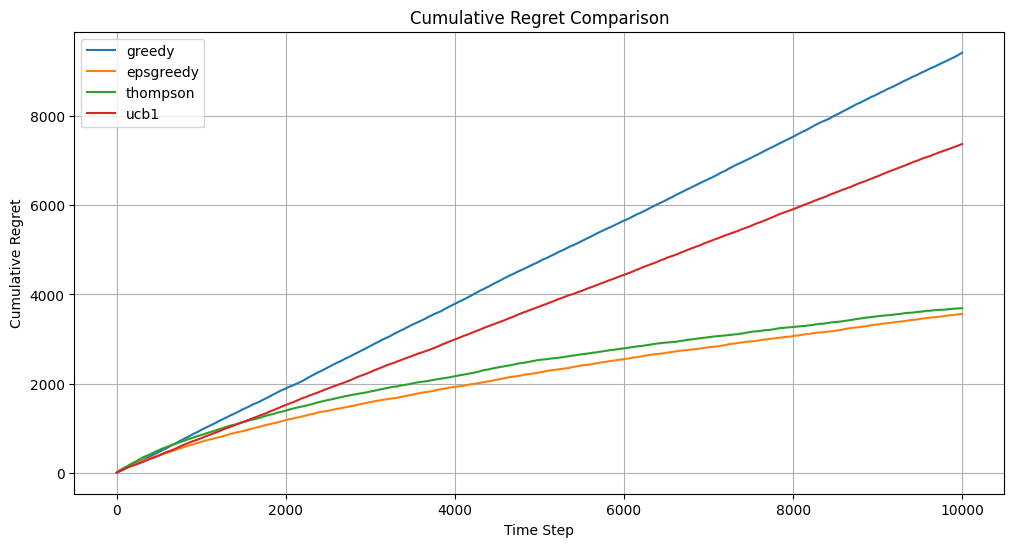

In [33]:
plt.figure(figsize=(12, 6))

for label in regret_curves:
    plt.plot(regret_curves[label], label=label)
    
plt.xlabel("Time Step")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Comparison")
plt.legend()
plt.grid(True)
plt.show()

`prices`: The different price options we are going to run it for are: [20, 30, 40, 50, 60]

`nstep`: # trial steps in every simulation is 10k.

`nepoch`: Total number of simulation runs before summarizing the results = 1000.

From the graph, Epsilon greedy and Thompson sampling is significantly outperforming compared to the other two methods. Clearly, Greedy is not working and UCB is not far. 

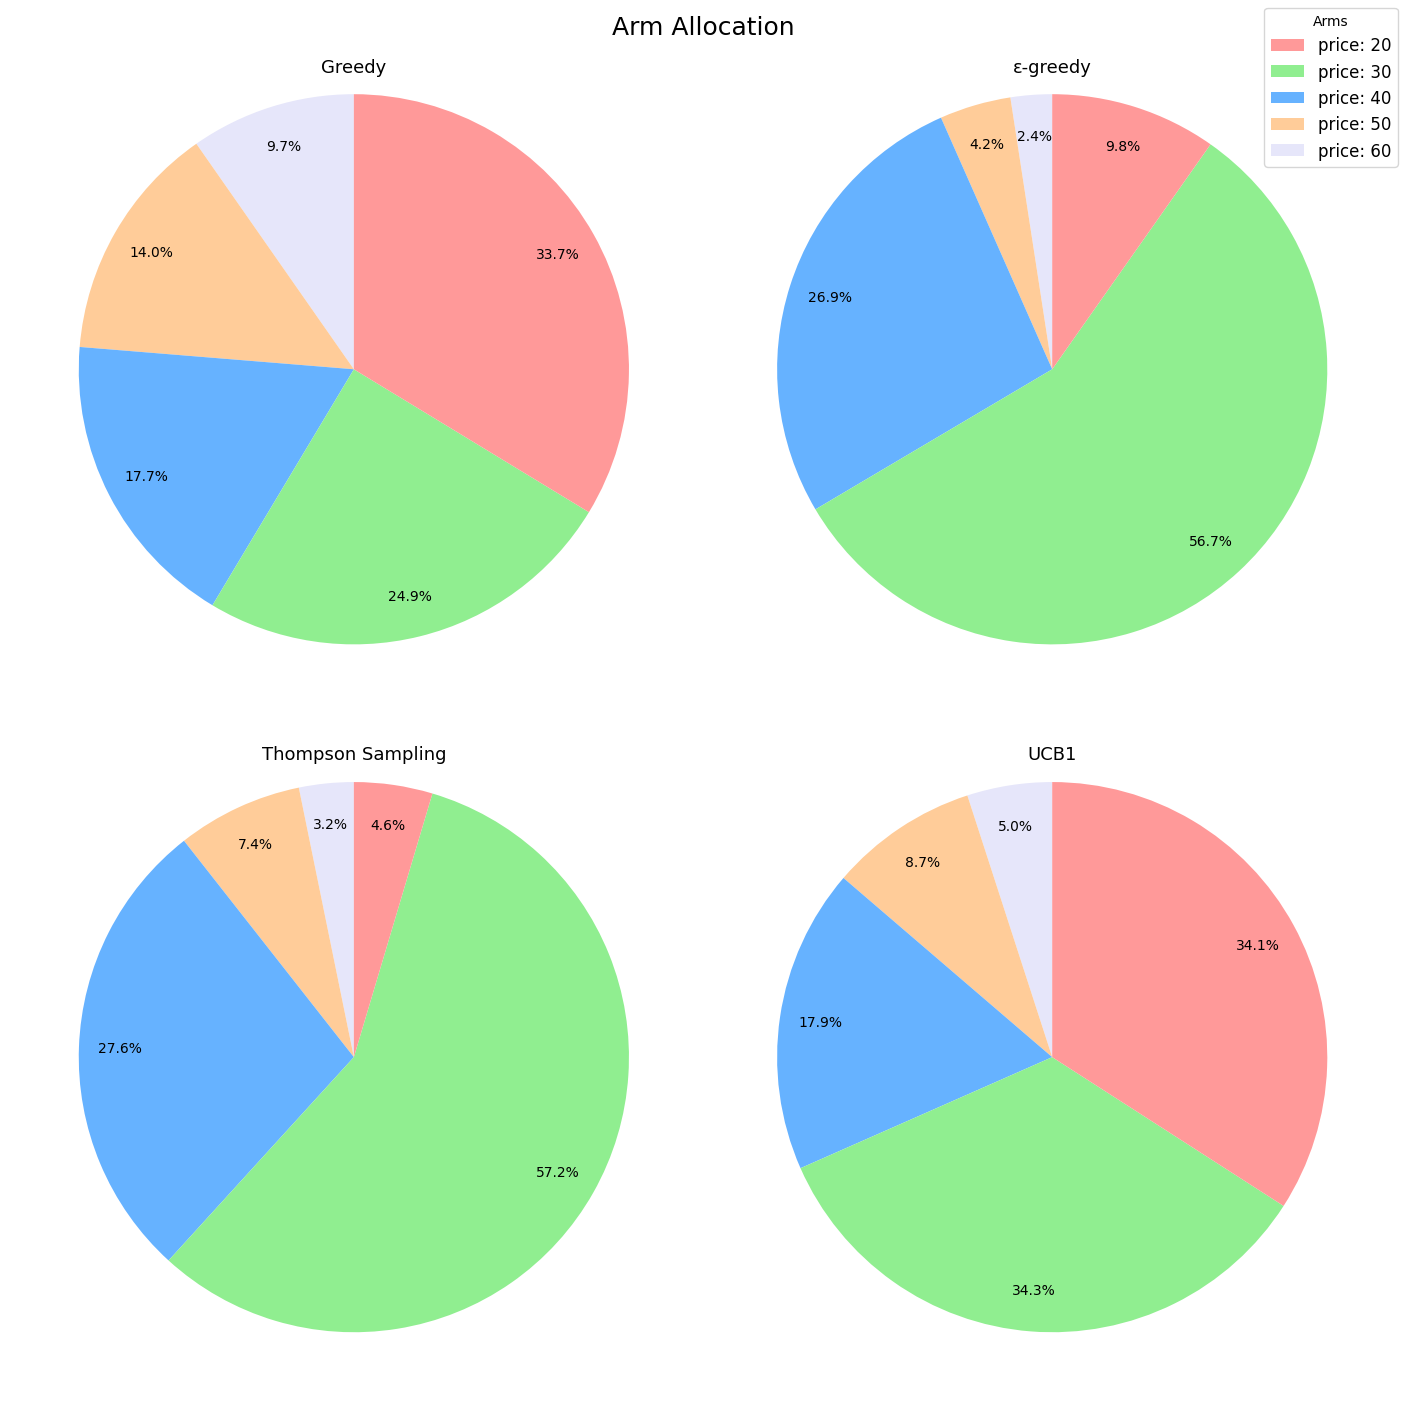

In [36]:
def plot_arm_allocations(arm_allocations):
    colors = ['#FF9999', 'lightgreen', '#66B2FF', '#FFCC99', '#E6E6FA']
    labels_with_price = ["price: 20", "price: 30", "price: 40", "price: 50", "price: 60"]
    strategy_titles = ["Greedy", "ε-greedy", "Thompson Sampling", "UCB1"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle("Arm Allocation", fontsize=18, y=0.99)
    axes = axes.ravel()

    for i, strategy in enumerate(strategy_titles):
        ax = axes[i]
        wedges, texts, autotexts = ax.pie(
            arm_allocations[i][::-1],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors[::-1],
            pctdistance=0.85,
        )

        # Increase the size and weight of the percentage labels
        for text in autotexts:
            text.set(size=10)

        ax.set_title(strategy, fontsize=13, y=0.92)

    fig.legend(wedges[::-1], labels_with_price, title="Arms", loc="upper right", fontsize='large')
    plt.tight_layout(pad=0.01)
    plt.show()

# Data from the simulation run results
arm_allocations = [
    [33.69363, 24.89811, 17.70132, 14.00271, 9.70423],  # greedy
    [9.76318, 56.73229, 26.87944, 4.19293, 2.43216],    # epsgreedy
    [4.60987, 57.15172, 27.64446, 7.38585, 3.2081],     # thompson
    [34.09561, 34.29079, 17.90161, 8.72104, 4.99095]     # ucb1-0.7-norm
]

# Plotting
plot_arm_allocations(arm_allocations)


## 11. Why Thompson sampling has slower reactivity than expected?

Results from a sample run:

    Strategy: greedy
    Regret -> mean: 9424.76, median: 10644.25, std: 8618.17
    Reactivity -> mean: 3540.91, median: 196.00, std: 4633.76
    Arm Allocation -> [33.69363 24.89811 17.70132 14.00271  9.70423]
    -------------
    Strategy: epsgreedy
    Regret -> mean: 3563.40, median: 3194.25, std: 2754.31
    Reactivity -> mean: 1792.71, median: 210.50, std: 3097.08
    Arm Allocation -> [ 9.76318 56.73229 26.87944  4.19293  2.43216]
    -------------
    Strategy: thompson
    Regret -> mean: 3694.33, median: 3659.25, std: 1965.27
    Reactivity -> mean: 1900.38, median: 247.50, std: 2973.80
    Arm Allocation -> [ 4.60987 57.15172 27.64446  7.38585  3.2081 ]
    -------------
    Strategy: ucb1
    Regret -> mean: 7375.68, median: 5454.25, std: 7476.65
    Reactivity -> mean: 3322.09, median: 177.00, std: 4556.51
    Arm Allocation -> [34.09561 34.29079 17.90161  8.72104  4.99095]

The regret values (both mean and median) for epsilon greedy and thompson sampling is significantly lower than the other two methods.

However, from reactivity perspective, Thompson sampling is much slow than ALL three approaches. 

Why is this so?

Earlier when studying Thompson sampling logic, we saw, TS estimates purchase probabilities. 

However, the decision of picking the best arm is made based on the PRODUCT of the probabilities and the prices, which is the 'expected rewards'. 

Having knowledge of the real probabilities (example: [0.60, 0.44, 0.31, 0.22, 0.15]) allows us to calculate the expected rewards by multiplying the probabilities with the corresponding prices. So TS decides based on the expected rewards which are fairly close to eachother: [12.06, 13.25, 12.56, 10.90, 8.93]. 

In essence, although the underlying probabilities differ considerably, the expected revenue values are relatively close from its perspective, especially in proximity to the optimal price. 

So, TS requires more time to discriminate and infer the optimal arm. While TS is amongst top-performing algorithm, it needs more iterations to find the best arm, atleast in this context.

# SECTION 7: Improving the Algorithm 

## 12. Tuning UCB

Looking at the arm allocations, it behaves similar to the greedy algorithm, basically acting mostly in exploitative mode.

UCB1 seems to be only slightly better than the greedy approach.

But we can make it better. 

Fortunately, UCB1 has a tuning parameter C, which governs the level of explortion-exploitation that can be done. 

We can basically do two things:

1. Normalize the rewards in the UCB formula before adding the 'curiosity bonus'. This will help to ease the hyperparameter search by keeping the rewards consistent. So, instead of tuning for a wide range of values of C, we need to only search for values of C say between 0.5 ans 1.5.

2. Tune for various values of C, which gives lower regret and faster reactivity. 

__Redefine the UCB1 logic__

In [37]:
def UCB1(arm_avg_reward, arm_counter, iteration, C=1, normalize=True):     
    if np.all(arm_avg_reward == 0):        
        # if we have not gotten any reward, go random
        arm = np.random.choice(len(arm_avg_reward))  
        return arm  
    if 0 in arm_counter:  
        # if there's an arm that hasn't been pulled yet, pull it.
        arm = np.argmin(arm_counter)
        return arm
    # Total number of times any arm has been played
    total_plays = iteration + 1  # since iteration starts from 0
    
    if normalize:
        max_reward = arm_avg_reward.max()
        arm_norm_reward = arm_avg_reward/max_reward
        # Calculate upper bounds for all arms
        ucb_values = arm_norm_reward + C * np.sqrt(2 * np.log(total_plays) / arm_counter)
        ucb_values *= max_reward
    else:        
        # calculate upper bounds for all arms
        ucb_values = arm_avg_reward + C * np.sqrt(2 * np.log(total_plays) / arm_counter)
    
    # Return the arm which has the maximum upper bound
    return np.argmax(ucb_values)

__Re-run the simulation, only for updated UCB__

In [39]:
prices = [20, 30, 40, 50, 60]
nstep = 10000
nepoch = 1000
regret_curves = {}
for strategy in ["greedy", "epsgreedy", "thompson", "ucb1"]:
    regret_curves[strategy] = np.zeros((nstep,)) 
    regrets = []
    reactivities = []
    arm_counters = np.zeros((len(prices),))
    for ep in range(nepoch):
        regret, reactivity, arm_counter = run_simulation(prices, nstep, strategy=strategy)
        regret_curves[strategy] += regret
        regrets.append(regret[-1])
        reactivities.append(reactivity)
        arm_counters += arm_counter/nstep
    regret_curves[strategy] /= nepoch
    arm_allocation = 100*arm_counters/nepoch
    print("-------------\nStrategy: %s" %strategy)    
    print("Regret -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(regrets), np.median(regrets), np.std(regrets)))
    print("Reactivity -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(reactivities), np.median(reactivities), np.std(reactivities)))
    print("Arm Allocation -> %s" %(arm_allocation))

-------------
Strategy: greedy
Regret -> mean: 9083.88, median: 10434.25, std: 8314.76
Reactivity -> mean: 3513.26, median: 164.00, std: 4619.65
Arm Allocation -> [35.59495 25.298   18.80074 11.60226  8.70405]
-------------
Strategy: epsgreedy
Regret -> mean: 3488.35, median: 3054.25, std: 2678.92
Reactivity -> mean: 1473.44, median: 161.00, std: 2822.62
Arm Allocation -> [ 8.57439 58.07466 26.60315  4.31336  2.43444]
-------------
Strategy: thompson
Regret -> mean: 3697.44, median: 3614.25, std: 1983.16
Reactivity -> mean: 1788.07, median: 234.00, std: 2879.08
Arm Allocation -> [ 4.80357 57.1211  27.95132  6.8729   3.25111]
-------------
Strategy: ucb1
Regret -> mean: 2969.07, median: 2874.25, std: 1790.58
Reactivity -> mean: 1094.80, median: 174.50, std: 2078.14
Arm Allocation -> [ 7.85225 63.24439 23.34661  4.12927  1.42748]


__Regret curves updated__

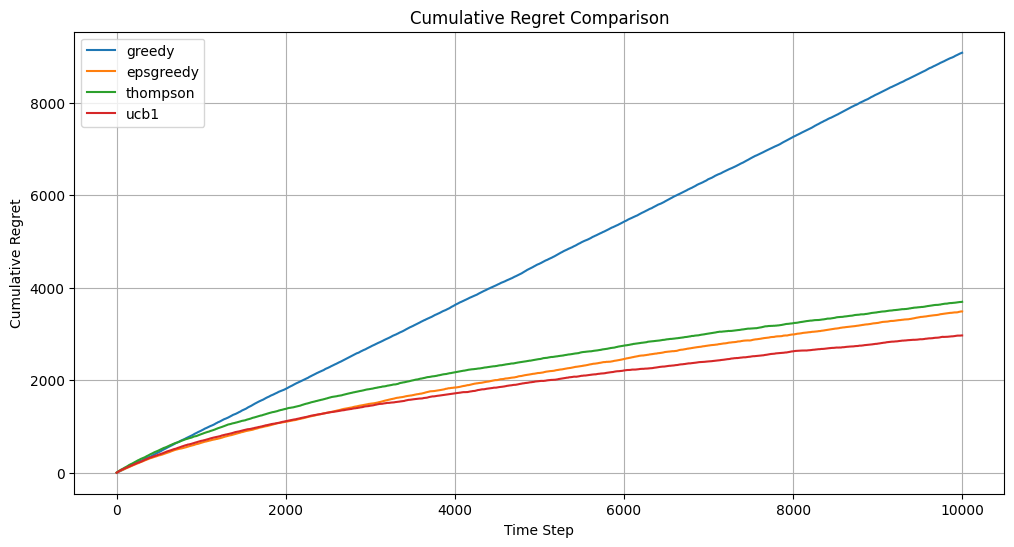

In [40]:
plt.figure(figsize=(12, 6))

for label in regret_curves:
    plt.plot(regret_curves[label], label=label)
    
plt.xlabel("Time Step")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Comparison")
plt.legend()
plt.grid(True)
plt.show()

As a result of this tuning, UCB has taken the first spot. 

Can we do better?

Let's set C=0.7 and check. Ideally, we should modify the `ucb1` call inside the `run_simulation` function. But, for now modifying the UCB defn is easier. 

In [41]:
def UCB1(arm_avg_reward, arm_counter, iteration, C=0.7, normalize=True):     
    if np.all(arm_avg_reward == 0):        
        # if we have not gotten any reward, go random
        arm = np.random.choice(len(arm_avg_reward))  
        return arm  
    if 0 in arm_counter:  
        # if there's an arm that hasn't been pulled yet, pull it.
        arm = np.argmin(arm_counter)
        return arm
    # Total number of times any arm has been played
    total_plays = iteration + 1  # since iteration starts from 0
    
    if normalize:
        max_reward = arm_avg_reward.max()
        arm_norm_reward = arm_avg_reward/max_reward
        # Calculate upper bounds for all arms
        ucb_values = arm_norm_reward + C * np.sqrt(2 * np.log(total_plays) / arm_counter)
        ucb_values *= max_reward
    else:        
        # calculate upper bounds for all arms
        ucb_values = arm_avg_reward + C * np.sqrt(2 * np.log(total_plays) / arm_counter)
    
    # Return the arm which has the maximum upper bound
    return np.argmax(ucb_values)

Rerun the simulation iterations again.

In [42]:
prices = [20, 30, 40, 50, 60]
nstep = 10000
nepoch = 1000
regret_curves = {}
for strategy in ["greedy", "epsgreedy", "thompson", "ucb1"]:
    regret_curves[strategy] = np.zeros((nstep,)) 
    regrets = []
    reactivities = []
    arm_counters = np.zeros((len(prices),))
    for ep in range(nepoch):
        regret, reactivity, arm_counter = run_simulation(prices, nstep, strategy=strategy)
        regret_curves[strategy] += regret
        regrets.append(regret[-1])
        reactivities.append(reactivity)
        arm_counters += arm_counter/nstep
    regret_curves[strategy] /= nepoch
    arm_allocation = 100*arm_counters/nepoch
    print("-------------\nStrategy: %s" %strategy)    
    print("Regret -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(regrets), np.median(regrets), np.std(regrets)))
    print("Reactivity -> mean: %.2f, median: %.2f, std: %.2f" %(np.mean(reactivities), np.median(reactivities), np.std(reactivities)))
    print("Arm Allocation -> %s" %(arm_allocation))

-------------
Strategy: greedy
Regret -> mean: 9798.95, median: 10844.25, std: 8550.58
Reactivity -> mean: 3819.35, median: 234.00, std: 4702.75
Arm Allocation -> [33.8942  23.89838 17.20145 15.40162  9.60435]
-------------
Strategy: epsgreedy
Regret -> mean: 3517.46, median: 3109.25, std: 2755.14
Reactivity -> mean: 1567.60, median: 177.00, std: 2949.82
Arm Allocation -> [ 8.99265 57.98445 26.45453  4.12794  2.44043]
-------------
Strategy: thompson
Regret -> mean: 3734.96, median: 3684.25, std: 1861.74
Reactivity -> mean: 1737.19, median: 229.50, std: 2785.88
Arm Allocation -> [ 4.74122 55.41221 29.37622  7.28661  3.18374]
-------------
Strategy: ucb1
Regret -> mean: 2397.49, median: 2104.25, std: 2418.37
Reactivity -> mean: 1088.65, median: 165.00, std: 2246.46
Arm Allocation -> [ 7.67006 67.89005 21.11289  2.59332  0.73368]


__Plot the regret curves__

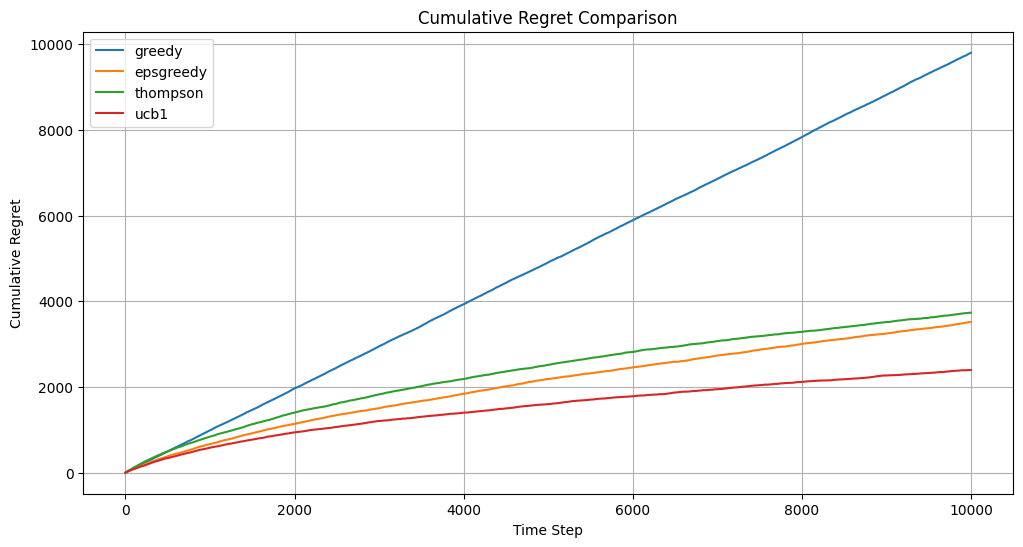

In [43]:
plt.figure(figsize=(12, 6))

for label in regret_curves:
    plt.plot(regret_curves[label], label=label)
    
plt.xlabel("Time Step")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Comparison")
plt.legend()
plt.grid(True)
plt.show()

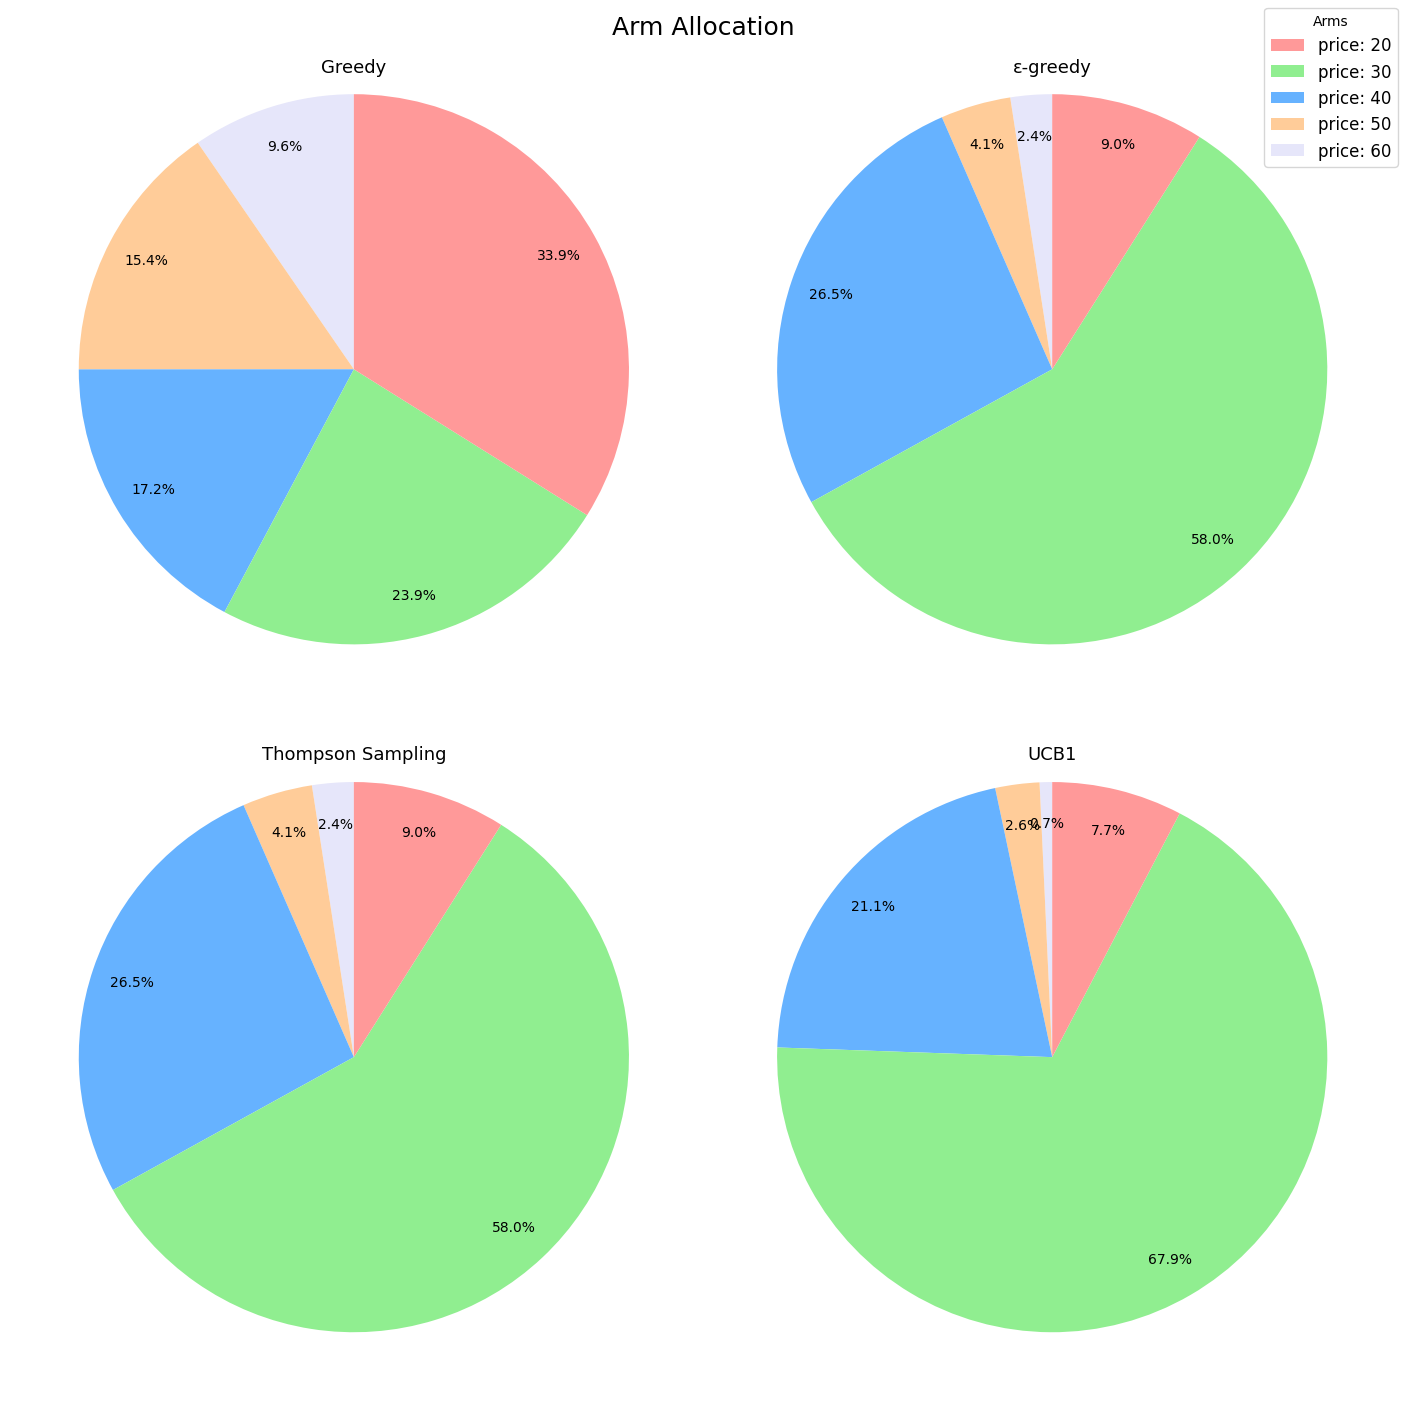

In [44]:
# Data from the simulation run results
arm_allocations = [
    [33.8942,  23.89838, 17.20145, 15.40162,  9.60435],  # greedy
    [8.99265, 57.98445, 26.45453,  4.12794,  2.44043],    # epsgreedy
    [8.99265, 57.98445, 26.45453,  4.12794,  2.44043],     # thompson
     [7.67006, 67.89005, 21.11289,  2.59332,  0.73368]     # ucb1-0.7-norm
]

# Plotting
plot_arm_allocations(arm_allocations)
